<a href="https://colab.research.google.com/github/Juliaroch/Ironhack-final-project-Julia-Roch/blob/master/Training_CNN_ResNet50%20(epoch36).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib 
import matplotlib.pyplot as plt
import random
from sklearn import metrics

In [0]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Import the images from 11 artists I need for my training
images_dir = '/content/gdrive/My Drive/Final_project_data/resized_train_test'
data_artists = pd.read_csv('/content/gdrive/My Drive/Final_project_data/data_artists.csv')
artists_dirs = os.listdir(images_dir)
artists_top_name = data_artists['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))


Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Vincent_van_Gogh
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pablo_Picasso
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pierre-Auguste_Renoir
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Francisco_Goya
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Albrecht_Dürer
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Alfred_Sisley
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Marc_Chagall
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Edgar_Degas
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Rembrandt
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Titian
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Paul_Gauguin


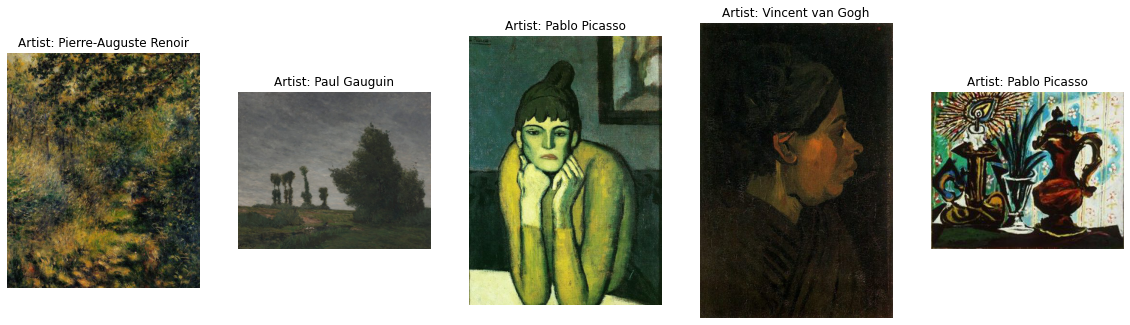

In [0]:
#See if images have been imported correctly 
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [0]:
#Train_test_split
batch_size = 32
train_input_shape = (128, 128, 3)
n_classes = artists_top_name.shape[0]

train_datagen=ImageDataGenerator(validation_split=0.1,rescale=1./255.,horizontal_flip=True,vertical_flip=True)
                                 
train_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="training",shuffle=True,classes=artists_top_name.tolist())
                                                   
valid_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="validation",shuffle=True,classes=artists_top_name.tolist())

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 2384 images belonging to 11 classes.
Found 262 images belonging to 11 classes.
Total number of batches = 74 and 8


In [0]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 2s 0us/step


In [0]:
X = base_model.output
X = Flatten()(X)

X = Dense(256, kernel_initializer='he_uniform')(X)
X = Dropout(0.25)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.25)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [0]:
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [0]:
n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')

In [0]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr], use_multiprocessing=True, workers=16)

Epoch 1/20
74/74 [==============================] - 701s 9s/step - loss: 1.9943 - acc: 0.3559 - val_loss: 4.0045 - val_acc: 0.0820
Epoch 2/20
74/74 [==============================] - 671s 9s/step - loss: 1.6783 - acc: 0.4949 - val_loss: 2.5595 - val_acc: 0.1680
Epoch 3/20
74/74 [==============================] - 672s 9s/step - loss: 1.5309 - acc: 0.5604 - val_loss: 5.5961 - val_acc: 0.0859
Epoch 4/20
74/74 [==============================] - 683s 9s/step - loss: 1.4211 - acc: 0.5876 - val_loss: 5.3186 - val_acc: 0.0938
Epoch 5/20
74/74 [==============================] - 678s 9s/step - loss: 1.3226 - acc: 0.6122 - val_loss: 3.0883 - val_acc: 0.0977
Epoch 6/20
74/74 [==============================] - 672s 9s/step - loss: 1.2258 - acc: 0.6535 - val_loss: 2.7940 - val_acc: 0.0859
Epoch 7/20
 8/74 [==>...........................] - ETA: 2:36 - loss: 6.3738 - acc: 0.0977
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
74/74 [==============================] - 6

In [0]:
for layer in model.layers[:50]:
   layer.trainable = False

for layer in model.layers[50:]:
   layer.trainable = True

optimizer = Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

n_epoch = 36
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr, early_stop], use_multiprocessing=True, workers=16)

Epoch 1/36
74/74 [==============================] - 549s 7s/step - loss: 0.8817 - acc: 0.7462 - val_loss: 20.6261 - val_acc: 0.2852
Epoch 2/36
74/74 [==============================] - 527s 7s/step - loss: 0.8572 - acc: 0.7628 - val_loss: 2.9272 - val_acc: 0.4844
Epoch 3/36
74/74 [==============================] - 539s 7s/step - loss: 0.7412 - acc: 0.8027 - val_loss: 1.5311 - val_acc: 0.5977
Epoch 4/36
74/74 [==============================] - 523s 7s/step - loss: 0.7366 - acc: 0.7921 - val_loss: 1.8768 - val_acc: 0.5703
Epoch 5/36
74/74 [==============================] - 521s 7s/step - loss: 0.6634 - acc: 0.8193 - val_loss: 1.1335 - val_acc: 0.6602
Epoch 6/36
74/74 [==============================] - 539s 7s/step - loss: 0.5947 - acc: 0.8321 - val_loss: 1.1859 - val_acc: 0.6680
Epoch 7/36
74/74 [==============================] - 533s 7s/step - loss: 0.5792 - acc: 0.8465 - val_loss: 1.8466 - val_acc: 0.5508
Epoch 8/36
74/74 [==============================] - 528s 7s/step - loss: 0.5178 - 

In [0]:
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

75/75 [==============================] - 169s 2s/step - loss: 0.0452 - acc: 0.9895
Prediction accuracy on train data = 0.9895134


In [0]:
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

9/9 [==============================] - 19s 2s/step - loss: 1.0127 - acc: 0.7290
Prediction accuracy on CV data = 0.72900766


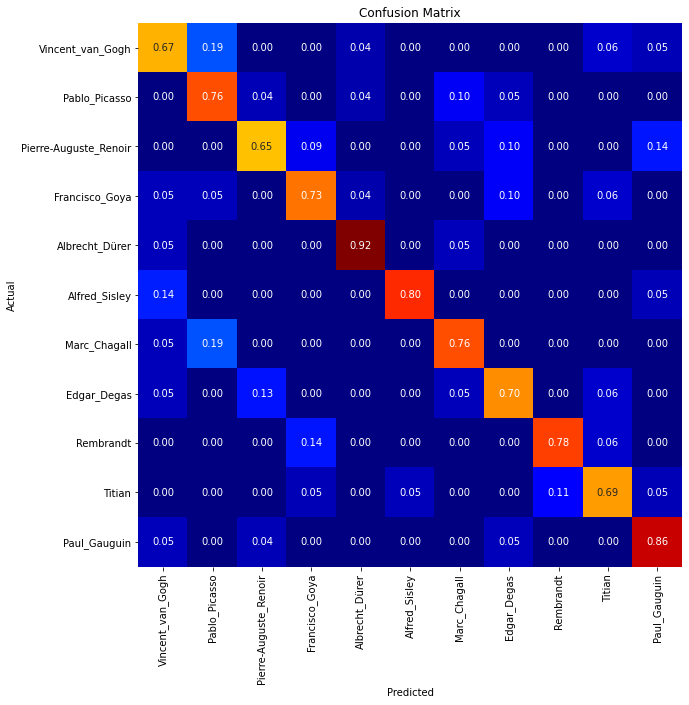

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.64      0.67      0.65        21
        Pablo_Picasso       0.64      0.76      0.70        21
Pierre-Auguste_Renoir       0.75      0.65      0.70        23
       Francisco_Goya       0.73      0.73      0.73        22
       Albrecht_Dürer       0.89      0.92      0.91        26
        Alfred_Sisley       0.94      0.80      0.86        20
         Marc_Chagall       0.76      0.76      0.76        21
          Edgar_Degas       0.70      0.70      0.70        20
            Rembrandt       0.88      0.78      0.82        18
               Titian       0.73      0.69      0.71        16
         Paul_Gauguin       0.76      0.86      0.81        22

             accuracy                           0.76       230
            macro avg       0.76      0.76      0.76       230
         weighted avg       0.77      0.76      0.76       230



In [0]:
 # Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)


In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

ValueError: ignored